In [30]:
import pandas as pd
%matplotlib inline
import pymc3 as pm

In [16]:
data = pd.read_csv('bandoro-microbiome.csv')
# data['Sample'] = data['Sample'].astype('category')

# Encode the "Sample" column with indices.
sample_names = list(set(data['Sample'].values))
for i, name in enumerate(sample_names):
    data['Sample'] = data['Sample'].replace(name, i)
data.head()

,Date,Sample,% GFP,Normalized % GFP
0,09.03.2016,8,15.90,98.148148
1,09.03.2016,8,16.50,101.851852
2,08.31.2016,8,26.00,108.559499
3,08.31.2016,8,21.90,91.440501
4,09.03.2016,12,1.84,11.358025


In [18]:
with pm.Model() as model:
    # Hyperpriors
    upper = pm.Exponential('upper', lam=0.05)
    # lower = pm.Exponential('lower', lam=1)

    # "fold", which is the estimated fold change.
    fold = pm.Uniform('fold', lower=1E-10, upper=upper, shape=len(sample_names))

    # Assume that data have heteroskedastic (i.e. variable) error but are drawn from the same distribution
    # sigma = pm.Gamma('sigma', alpha=1, beta=1, shape=n_genotypes+2)
    sigma = pm.HalfCauchy('sigma', beta=1, shape=len(sample_names))

    # Model prediction
    mu = fold[data['Sample']]
    sig = sigma[data['Sample']]

    # Data likelihood
    like = pm.Normal('like', mu=mu, sd=sig, observed=data['Normalized % GFP'])

Applied log-transform to upper and added transformed upper_log_ to model.
Applied interval-transform to fold and added transformed fold_interval_ to model.
Applied log-transform to sigma and added transformed sigma_log_ to model.


In [19]:
with model:
    n_steps = 300000
    params = pm.variational.advi(n=n_steps)
    trace = pm.variational.sample_vp(params, draws=2000)


Iteration 0 [0%]: ELBO = -266819.39
Iteration 30000 [10%]: Average ELBO = -28568.04
Iteration 60000 [20%]: Average ELBO = -283.13
Iteration 90000 [30%]: Average ELBO = -280.64
Iteration 120000 [40%]: Average ELBO = -280.02
Iteration 150000 [50%]: Average ELBO = -279.94
Iteration 180000 [60%]: Average ELBO = -279.94
Iteration 210000 [70%]: Average ELBO = -279.96
Iteration 240000 [80%]: Average ELBO = -280.03
Iteration 270000 [90%]: Average ELBO = -280.01
Finished [100%]: Average ELBO = -279.91


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120ab6320>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12571f240>]], dtype=object)

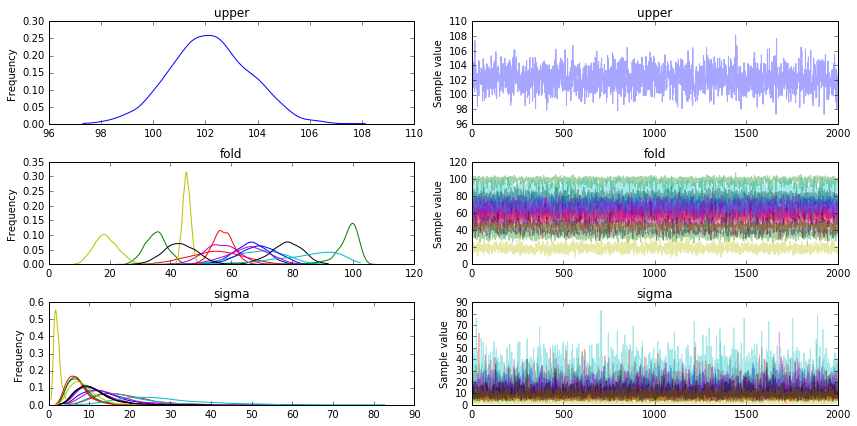

In [31]:
pm.traceplot(trace)

In [22]:
pm.summary(trace)


upper:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  102.184          1.529            0.037            [99.440, 105.365]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  99.170         101.166        102.151        103.206        105.122


fold:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  66.021           5.375            0.124            [56.094, 77.308]
  35.294           3.603            0.084            [28.448, 42.363]
  54.781           8.729            0.192            [37.180, 70.981]
  69.026           8.339            0.198            [52.779, 84.086]
  56.445           5.576            0.141            [45.574, 67.146]
  45.307           1.273            0.026      

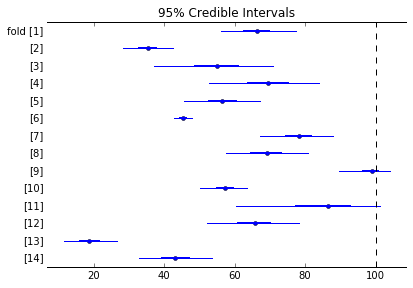

In [25]:
pm.forestplot(trace, varnames=['fold'], vline=100)
# plt.savefig('../figures/bandoro-microbiome.pdf')

In [28]:
for i, name in enumerate(sample_names):
    print(i+1, name)

1 B theta
2 E.coli BC15 (mouse)
3 E.coli K12 (?)
4 Pd
5 Bv
6 B fragilis
7 A mucin
8 Csc
9 Water
10 Ro
11 Bo
12 Er
13 S.typhi
14 PAO1
